In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns            # Not required Comment this line out 
import nltk                      # Not required Comment this line out
import re                        # Not required Comment this line out
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


In [2]:
fake = pd.read_csv('F:\\Lecture notes\\Sem-5\\MP-III\\Dataset\\Fake.csv')
real = pd.read_csv('F:\\Lecture notes\\Sem-5\\MP-III\\Dataset\\True.csv')

In [3]:
unknown_publishers = []
for index, row in enumerate(real.text.values):
    try:
        record = row.split('-', maxsplit = 1)
        record[1]
        assert(len(record[0])<120)
    except:
        unknown_publishers.append(index)

In [4]:
real = real.drop(8970, axis = 0)

In [5]:
publisher = []
tmp_text = []

for index, row in enumerate(real.text.values):
    if index in unknown_publishers:
        tmp_text.append(row)
        publisher.append('Unknown')

    else:
        record = row.split('-', maxsplit = 1)
        publisher.append(record[0].strip())
        tmp_text.append(record[1].strip())


In [6]:
real['publisher'] = publisher
real['text'] = tmp_text

In [7]:
empty_fake_index = [ index for index,text in enumerate (fake.text.tolist()) if str(text).strip() == ""]

In [8]:
real['text'] = real['title'] + " " + real['text']
fake['text'] = fake['title'] + " " + fake['text']

In [9]:
real['text'] = real['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

In [10]:
real['class'] = 1
fake['class'] = 0

In [11]:
real = real[['text', 'class']]
fake = fake[['text', 'class']]
data = real.append(fake, ignore_index=True)

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4
!pip install textblob
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

In [12]:
import preprocess_kgptalkie as ps
data['text'] = data['text'].apply(lambda x: ps.remove_special_chars(x))

In [ ]:
!pip install gensim

In [13]:
import gensim

In [14]:
y = data['class'].values
X = [d.split() for d in data['text'].tolist()]
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, window=10, min_count=1)

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [16]:
X = tokenizer.texts_to_sequences(X)

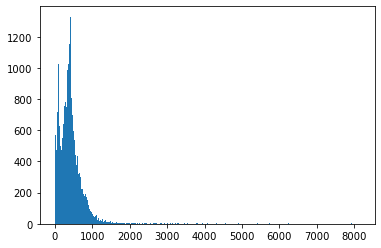

In [17]:
plt.hist([len(x) for x in X], bins = 700)
plt.show()

In [37]:
nos = np.array([len(x) for x in X])
len(nos[nos>1000])

1581

In [18]:
max_len = 1000
X = pad_sequences(X, maxlen = max_len)

In [19]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [20]:
def get_weight_matrix(model):
    weight_matrix = np.zeros((vocab_size, 100))
    
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    
    return weight_matrix

In [21]:
embedding_vectors = get_weight_matrix(w2v_model)

In [ ]:
embedding_vectors.shape

In [22]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim = 100, weights = [embedding_vectors], input_length = max_len, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         23187300  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 23,304,677
Trainable params: 117,377
Non-trainable params: 23,187,300
_________________________________________________________________


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [26]:
model.fit(X_train, y_train, validation_split = 0.3, epochs=6)

Epoch 1/6
737/737 [==============================] - 104s 142ms/step - loss: 0.0086 - acc: 0.9973 - val_loss: 0.0352 - val_acc: 0.9876
Epoch 2/6
737/737 [==============================] - 119s 161ms/step - loss: 0.0071 - acc: 0.9978 - val_loss: 0.0237 - val_acc: 0.9938
Epoch 3/6
737/737 [==============================] - 182s 247ms/step - loss: 0.0052 - acc: 0.9986 - val_loss: 0.0223 - val_acc: 0.9947
Epoch 4/6
737/737 [==============================] - 125s 170ms/step - loss: 0.0046 - acc: 0.9988 - val_loss: 0.0270 - val_acc: 0.9934
Epoch 5/6
737/737 [==============================] - 129s 175ms/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.0269 - val_acc: 0.9937
Epoch 6/6
737/737 [==============================] - 116s 157ms/step - loss: 0.0053 - acc: 0.9985 - val_loss: 0.0267 - val_acc: 0.9931


In [27]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)

In [28]:
accuracy_score(y_test, y_pred)

0.9942093541202672

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5921
           1       1.00      0.99      0.99      5304

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [38]:
x = ["""India reported 8,774 new COVID-19 cases and 621 related fatalities on Saturday, pushing the overall cases tally to 3,45,72,523 and the death count to 4,68,554. Besides, 9,481 recoveries were also reported during the previous 24 hours. The recovery rate now stands at 98.34 per cent, the highest since March 2020. At little over a lakh, active cases in the country stand at 1,05,069.

Meanwhile, reports of a new Covid variant, named 'Omicron' by the WHO and declared as a variant of concern, which was first detected in South Africa, has triggered concerns across the world, with several countries imposing travel bans on multiple southern African nations. 

The new strain has already been detected in several European countries, including UK, Germany, Italy, and Czech Republic. The variant is said to be much more infectious than the Delta variant and the "most heavily mutated" version of coronavirus discovered so far."""] 
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen = max_len)

In [39]:
news = (model.predict(x)>=0.5).astype(int)

In [40]:
if news == 1:
    print("It's a Real News")
else:
    print("It's a Fake News")

It's a Real News
